# Creating a Macro Model for Trading Cryptocurrencies.


## Introduction

In this Notebook we provide some models based on the on-chain data for hedging risks during technical systematic trading.
From the technical analysis point of view, we were able to asses that the major Cryptocurrencies, i.e. Bitcoin (BTC), ETH (Ethereum), 
Litecoin (LTC) and finally Ripple (XRP), are in a strong trend, meaning that there are not mean reversion opportunities at this macro stage of the overall cryptocurrency market. Therefore, it makes sense to capture value by using trend following strategies such as crossing of moving averages. Despite technical analysis assumes a full efficiency of the market, in reality it might not always be the case. Indeed, the scope of this work is to show that fundamental data correlate with price movement in a sensible way. We should take advantage of these data to hedge our systematic strategies from risks.


Some readers might ask what exactly are fundamental data in the case of cryptocurrencies. We should firstly say that what we consider to be fundamentals in cryptocurrency markets differs from the fundamentals of stock market. In the latter the market capitalisation, the price to book ratio, earnings play a big role for informed decision, but since cryptocurrencies are more similar to commodities (rather than a company stock), market capitalisation is an inexact and misleading measure. Indeed, cryptocurrencies are almost in a one to one correspondence with a supply and demand model, where the supply is indeed the quantity of coin released/mined and the demand is the rate of transaction and the active account that **consumes** the commodity.


Cryptocurrencies are an emerging new asset class and it has been unclear what factors determine their prices and returns. On the one hand, most empirical research focuses on the influence of investor sentiment and other non-fundamental factors. On the other hand, theory suggests that blockchain characteristics such as network size, transaction count and computing power are key determinants of prices. However, there is little empirical work on the importance of blockchain characteristics on price dynamics. Motivated by this gap in the empirical literature, we focus on the network size and computing power and examine if these blockchain characteristics can explain the dynamics of cryptocurrency prices and the cross-sectional variation in expected cryptocurrency returns.

## Structure of The Work

In the first part we focus on pulling the data and describing pictorially the chosen metrics. In the second part we test some assumptions on the drop in correlation of some of these metrics and what is the impact of that in the price movement. In the third part we try to build some machine learning strategies to see if the chosen on chain data can predict itself the direction of the daily returns.



In [1]:
%load_ext autoreload
%autoreload 2

In [120]:
#All modules needed for this part

import json
import requests
import pandas as pd
import numpy as np
import math
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


from arch.unitroot.cointegration import DynamicOLS

from TestStrategy.macromodel import Forest, Logit, Linearized
from AnalyticsTools.correlation import ClassicCorrelation
from AnalyticsTools.pullclean_featuring import GetnClean, create_lagsnleads
from AnalyticsTools.QuantitativeAnalytics import DetectAnomaly

import warnings
warnings.filterwarnings("ignore")

# Part I: Pulling the On-Chain data

In this section we pull the On-Chain data and we do a first exploration of the data.
We choose as data provider Glassnode, https://glassnode.com. 

The choosen metrics are the following:

- From Adresses we scrape the number of active adresses, this metric is know as *network size* or NET.
- From Mining we scrape the hash_rate_mean, this is the computational power (cp) expended to create minable cryptocurrencies.
- From transactions we scrape the count of the daily transaction
- From market we scrape the daily settlement price in USD of BTC.

In [3]:
directories = ['addresses', 'mining', 'transactions', 'market']
data_name = ['active_count', 'hash_rate_mean', 'count', 'price_usd_close']

zipped = list(zip(directories, data_name))

all_data = []

for pair in zipped:
    
    data = GetnClean(directory = pair[0],
                    data_name = pair[1],
                    start_date = '2010-01-01').data
    
    all_data.append(data)

In [4]:
#Putting The Data In a pandas DataFrame format

net = all_data[0]
cp =  all_data[1]
trans = all_data[2]
price = all_data[3]

#we take the log transform of the data to avoid scaling issues.

data = pd.concat([np.log(net), np.log(cp), np.log(trans), price], axis = 1)
data.columns = ['net', 'cp', 'transaction', 'Close']
data = data.dropna()

#we compute the log returns of the data.

data['returns'] = np.log(np.ma.masked_invalid(data.Close/data.Close.shift(1)))
data = data.replace([-np.inf, np.inf], np.nan)
data.dropna(inplace = True)

In [5]:
data.head(10)

,net,cp,transaction,Close,returns
t,,,,,
2010-07-17,6.453625,21.160557,5.459586,0.049510,1.000000
2010-07-18,6.629363,21.176003,5.513429,0.085840,0.550310
2010-07-19,6.694562,21.148661,5.869297,0.080800,-0.060508
2010-07-20,6.590301,21.196871,6.023448,0.074733,-0.078051
2010-07-21,6.431331,21.328695,5.545177,0.079210,0.058176
2010-07-22,6.056784,21.057641,5.398163,0.055945,-0.347733
2010-07-23,6.154858,21.272555,5.379897,0.062283,0.107325
2010-07-24,6.669498,21.244923,6.558198,0.054540,-0.132759
2010-07-25,7.555905,21.456352,7.372746,0.050500,-0.076961


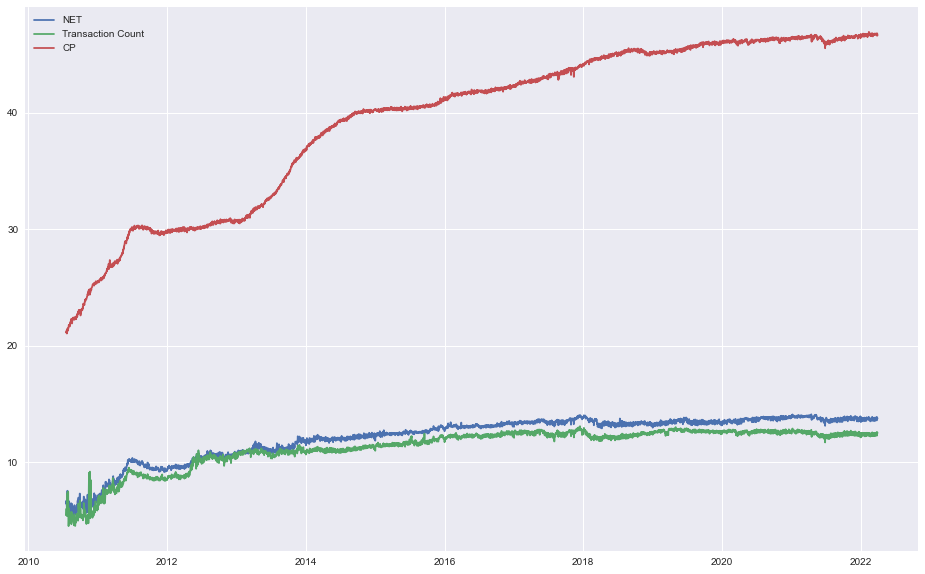

In [10]:
#Lets Plot The On Chain Data Together:

plt.figure(figsize = (16,10))

plt.plot(data.net, label = 'NET')
plt.plot(data.transaction, label = 'Transaction Count')
plt.plot(data.cp, label = 'CP')

plt.legend(loc = 'best')
plt.show()

From the above plot we could fairly asses a strong cointegration among all these on chain data. Cointegration means that the time series have a tendency over a long period to move together.


We shall also observe the movement of the price alongside these plots. To do so, since the magnitude of the plots greatly differs the magnitude of the price, we should simply do concatenated plots using the functionality of the pandas plotting. Furthermore, we consider more recent observation, we start the plotting from end of 2020.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f2bc996d0>,
      dtype=object)

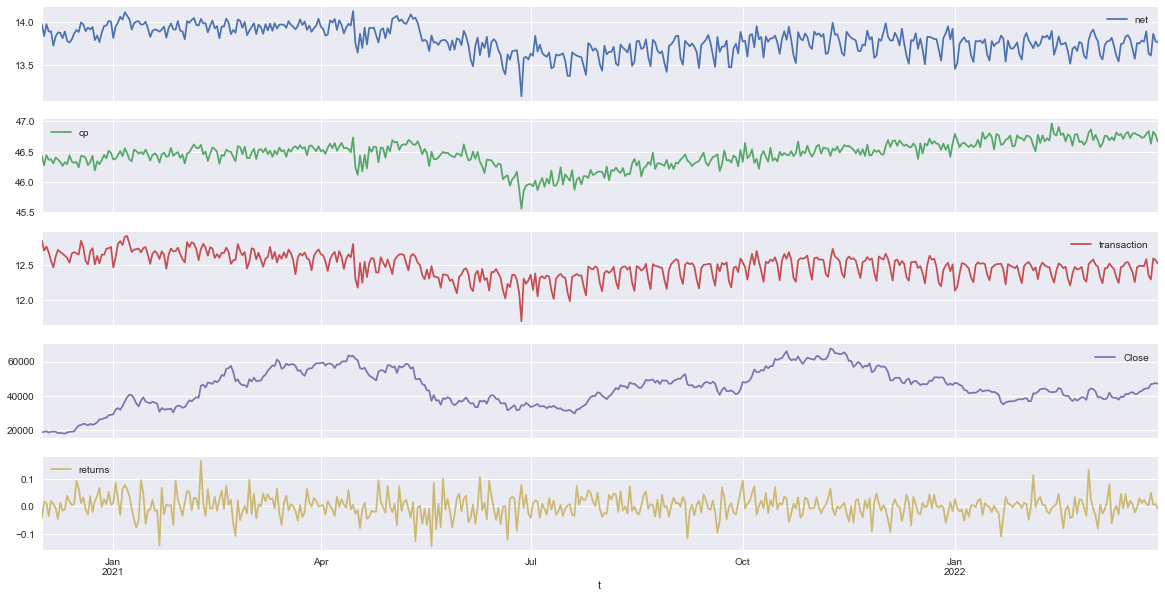

In [18]:
data['2020-12-01':].plot(figsize = (20,10), grid = True, subplots = True)

Whereas the computing power keeps increasing, we do not see so much impact on the price at a daily level, on the overall picture it tracks the upgrowing trend over this time. We should exclude for the moment this data, since we are trying to catch mostly daily trends. 
So we redo the plotting with just the net, transaction and the Close.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f2c4de250>,
      dtype=object)

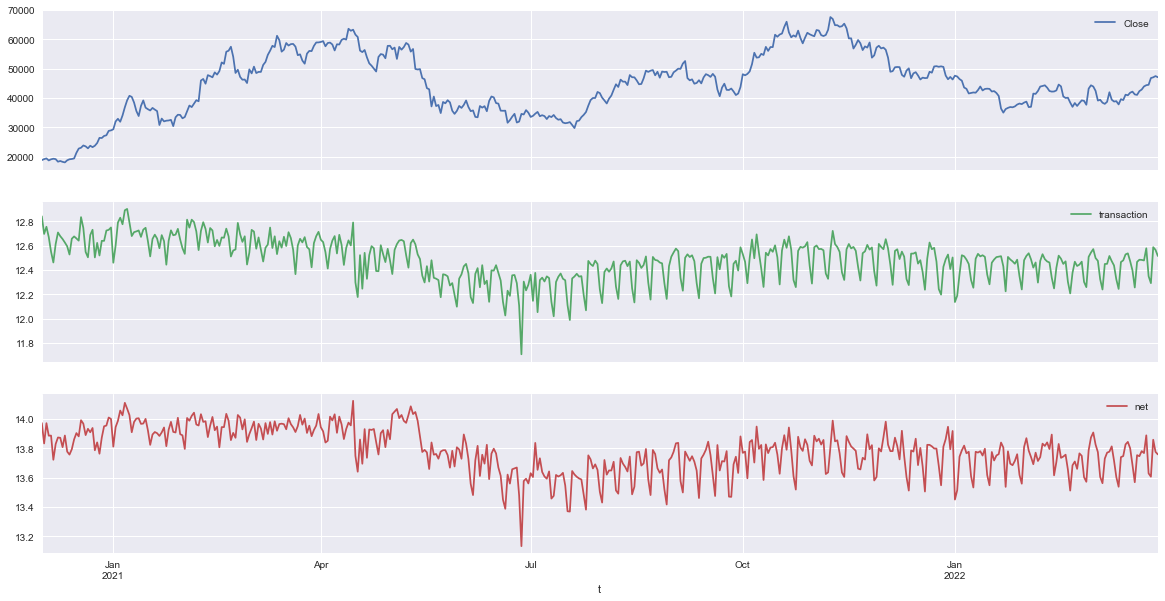

In [19]:
data[['Close', 'transaction', 'net']]['2020-12-01':].plot(figsize = (20,10), grid = True, subplots = True)

From the above plot we can appreciate a cointegrated movement between the price, the transaction count and the net. However it might be difficult to look at some alpha in this context. To look at the alpha we will need to build some indicator. This motivates the very next section.

# Part II: Assessing some rules from Indicators on the chosen On-Chain Data

In the last section we chosed as metrics the NET and the transaction count. Let's try to see how much of the pricing movement could they explain. To do so we proceed in the following way:

- Calculate the sample correlation of the choosen variables.
- Create a "rolling correlation" with some smoothing and plot it against the price.
- Elaborate a Signal on That.

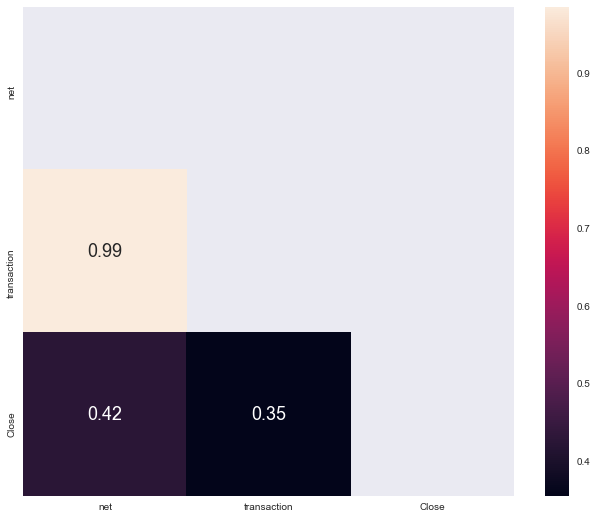

In [23]:
new_data = data[['net', 'transaction', 'Close']]

#We instantiate the class ClassicCorrelation
correlation = ClassicCorrelation(new_data, method = 'pearson')

#compute Sample Correlation
correlation.sample_correlation()

In the overall sample the number of transactions and the network size are heavily linearly dependent, whereas with respect to the price they maintain a linear independece. We shall look at the rolling correlation.

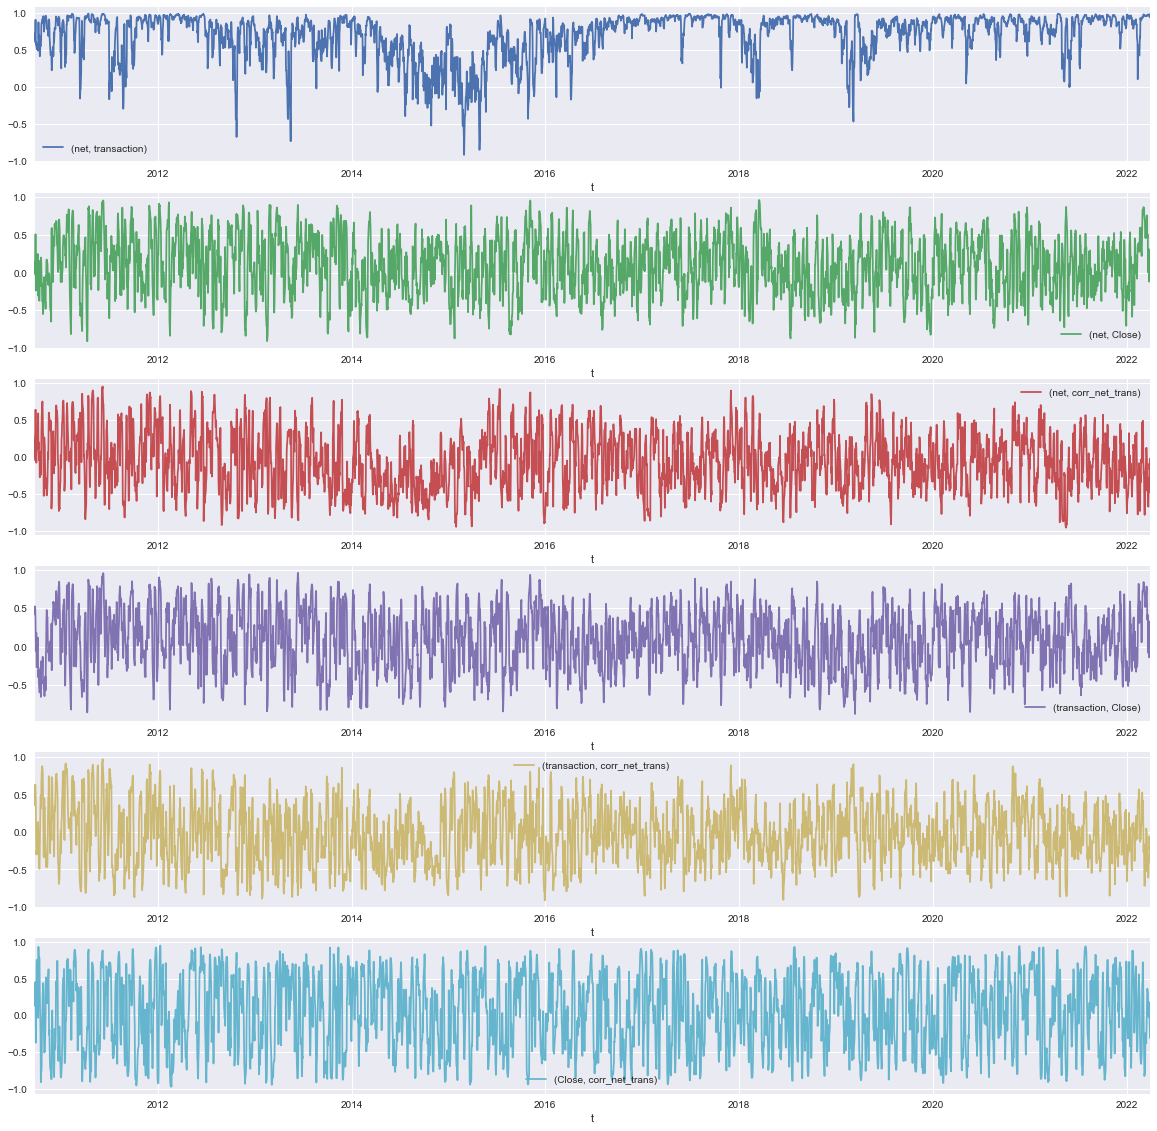

In [160]:
#We choose a window of 10 days
correlation.rolling_correlation(window = 10)

Over a rolling window it is clear that the number of transactions and the network size have a tendency to have peaks in correlation with the closing price. It is however interesting to see that there are some drops in correlation between the network size and the number of transaction.
We should see if this creates an explanatory variable for sudden regime switching of the BTC settlement price.

In [52]:
corr_df = correlation.corr_dataset
new_data['corr_net_trans'] = corr_df[corr_df.columns[0]]
new_data.dropna(inplace = True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f10b2d130>,
      dtype=object)

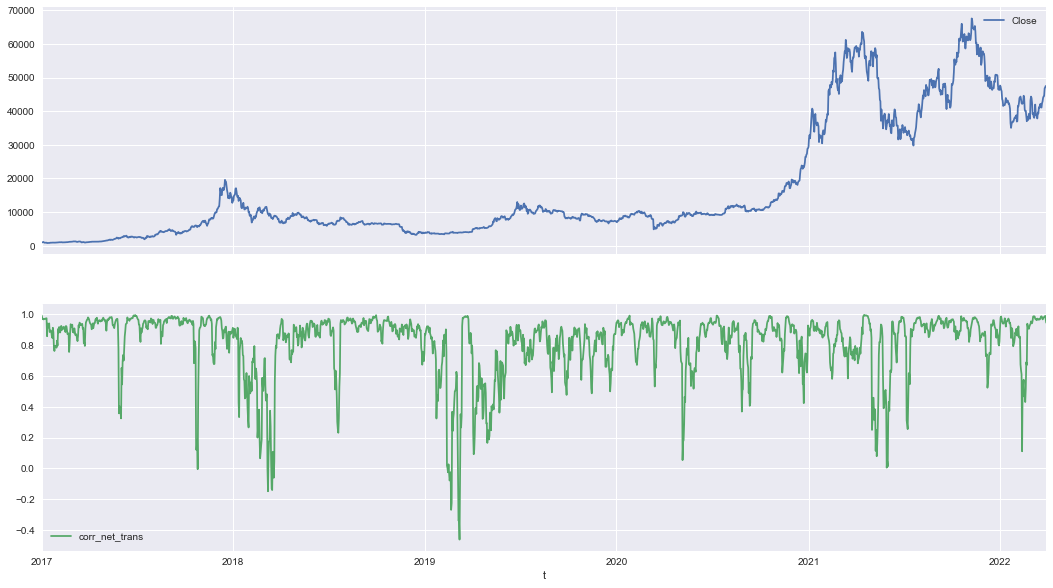

In [53]:
new_data[['Close', 'corr_net_trans']]['2017-01-01':].plot(figsize = (18,10), grid = True, subplots = True)

The above graph suggests that drops in correlation of the network size and the number of transaction cointegrates with changes in the settlement price. We should look at a most recent window where in the market there has been a lot more volatility.

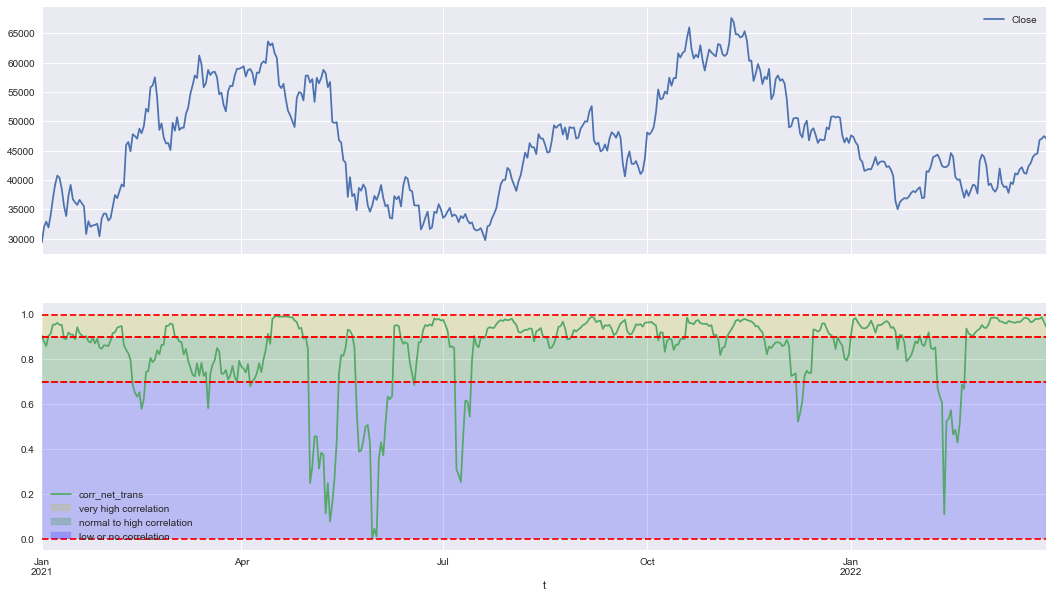

In [56]:
new_data[['Close', 'corr_net_trans']]['2021-01-01':].plot(figsize = (18,10), grid = True, subplots = True)


#very high correlation

plt.axhline(1.0, linestyle = '--', color = 'r')
plt.axhspan(ymin = 0.9, ymax = 1.0, color = 'y', alpha = 0.2, label = 'very high correlation')
plt.axhline(0.90, linestyle = '--', color = 'r')


#normal to high correlation
plt.axhline(0.70, linestyle = '--', color = 'r')
plt.axhspan(ymin = 0.7, ymax = 0.9, color = 'g', alpha = 0.2, label = 'normal to high correlation')
plt.axhline(0.90, linestyle = '--', color = 'r')


#low correlation
plt.axhline(0.0, linestyle = '--', color = 'r')
plt.axhspan(ymin = 0.0, ymax = 0.7, color = 'b', alpha = 0.2, label = 'low or no correlation')
plt.axhline(0.7, linestyle = '--', color = 'r')

plt.legend(loc = 'best')
plt.show()

## Remark

We can see that with a smoothing of 10 days the correlation indicator is able to give an overview of the drops in the price, namely when the correlation is low we can see large drops in the price. To make sense in a fundamental way, we could assert that the uncertainty driven by the low correlation between the network size and the transaction count generates a regime switch in the process related to the price. More specifically, uncertainty in the demand cause depreciation in the price.


We will end this section by confirming this information from a PnL point of view by generating a simple version of a backtest.

In [163]:
trading = data[['Close']]
trading['correlation'] = corr_df[corr_df.columns[1]]
trading['rets'] = data.returns #these are log returns
trading['position'] = np.where(trading.correlation < 0.7, -1, 0) #When correlation is low we should short sell

trading['sreturns'] = trading.position.shift(1)*trading.rets #calculate the returns
trading['csreturns'] = trading.sreturns.cumsum().apply(np.exp) #convert the log cumulative sum to multiple

trading.dropna(inplace = True)

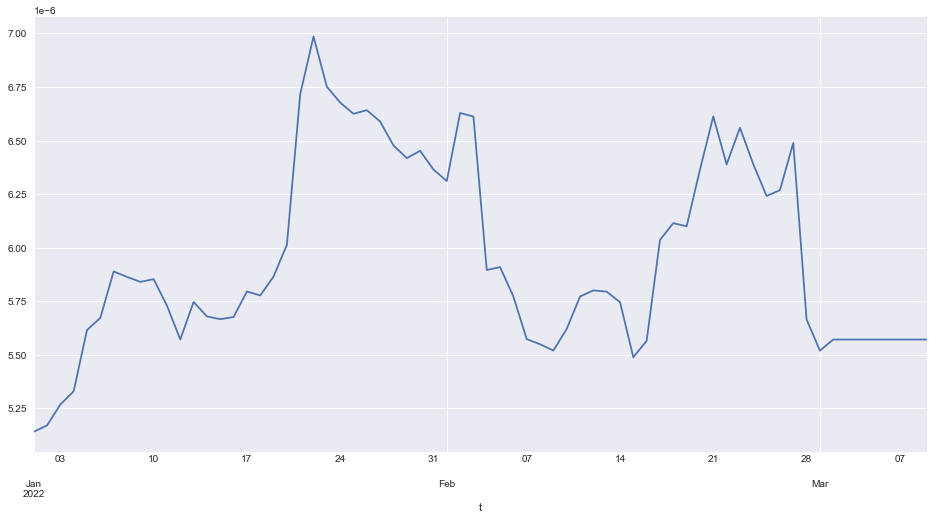

In [168]:
trading['2022-01-01':].csreturns.plot(figsize = (16,8))

# Conclusion

By looking at the final PnL we don't see a great strategy, however we did not optimize the window length of the rolling correlation, but we can see that on average there is an indication of how we could use this strategy into risk management. Namely, when the correlation between the network size and the transaction count drops then a drop in the price should be accepted, that means we could or ignore the long signal when this happens or we could tigth the stop losses and the take profit. Conversely when we are short, then we could move the take profit to be more aggressive.

# Some Extra Research

In the introduction we mentioned some fundamental data. In this section, for purely speculative reasons, we have build a few machine learning models to see if through the fundamental data we could predict the direction of the returns. This amounts to ask if the current factor models tailored for the cryptocurrency market are mature enough to be profitable. Namely, we should asses with the above data if what happens in the demand side could have any predictive ability on the daily return movement.

We organise the workflow for this part as follows:

- Section 1: Feature enginering, seasonality and DOLS in the log returns of the settlement price.
- Section 2: Training and testing a regularized regression with the fundamental data.
- Section 3: Training and testing classification models: Logistic Regression and Random Forest.

In [67]:
rets = data.returns[1:]

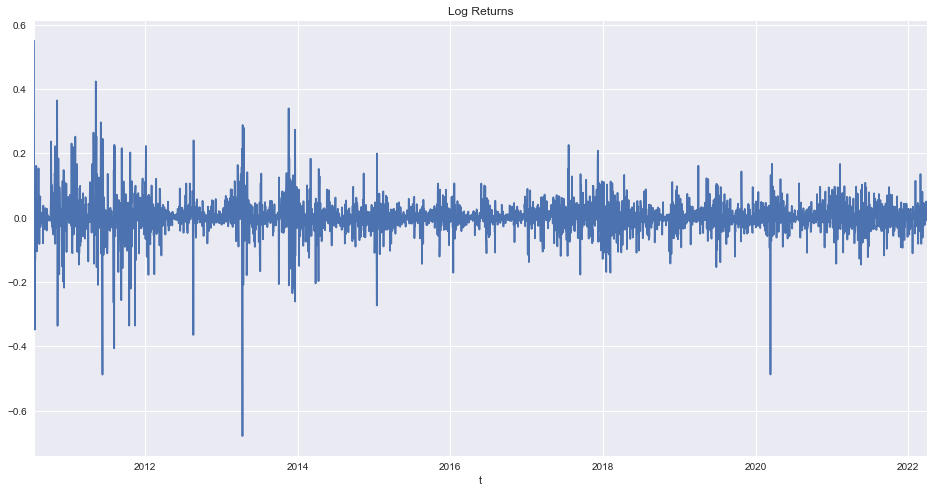

In [69]:
rets.plot(figsize = (16,8), grid = True, title = 'Log Returns')

In [109]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [110]:
#Create Chunks for bootstrapping the weekly seasonality from recent observations
chunks = list(chunks(rets['2021-01-01':], 14))[:-1]

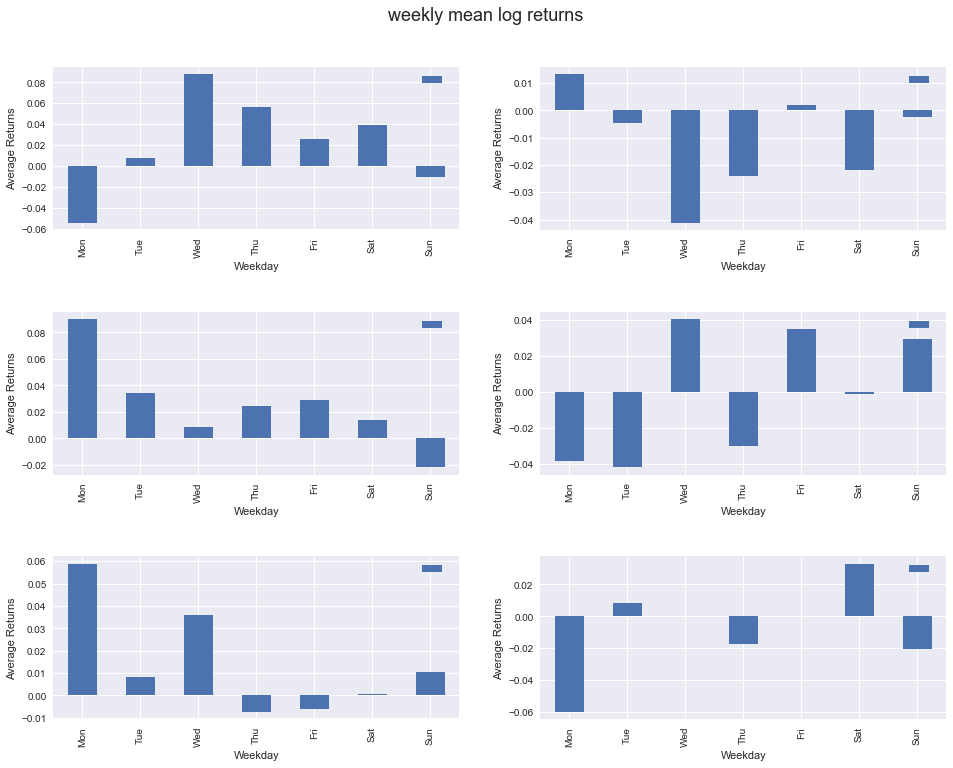

In [112]:
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("weekly mean log returns", fontsize=18, y=0.95)

for n in range(len(chunks)):
    
    try:
        
        ax = plt.subplot(3, 2, n + 1)


        resample = chunks[n].to_frame('').groupby(chunks[n].index.weekday).mean()
        resample.index = pd.Series(resample.index).apply(lambda x: calendar.day_abbr[x]).values.tolist()
        resample.plot(ax = ax, kind = 'bar')
        
    except:
        
        ValueError
        
    ax.set_xlabel('Weekday')
    ax.set_ylabel('Average Returns')
    

We conclude that there is not an apparent seasonality in the returns. Therefore we shall not consider any seasonal factors for this analysis.

Next we use a Dynamic Ordinary Least Squares (DOLS) for exploring the order of the lags and leads we should consider in the data.

In [121]:
dols = DynamicOLS(y = data.returns, x = data.loc[:, data.columns != 'returns'], trend = 'n', method = 'aic').fit(cov_type='robust')

In [127]:
print('='*100)
print('\n')
print('Estimated Number of Leads:', dols.leads)
print('-'*100)
print('Estimated Number of Lags:', dols.lags)
print('\n')
print('='*100)



Estimated Number of Leads: 22
----------------------------------------------------------------------------------------------------
Estimated Number of Lags: 26




Usage of NET decreases towards the weekend. NET is the network size, and CP is the computing power, i.e. the hashrate

In [129]:
lags_leads = create_lagsnleads(data[['cp', 'net', 'transaction']], n_lag = 26, n_lead = 22)

data = pd.concat([data, lags_leads], axis = 1)

## A simple linear regression model

The code for this strategy is in the macromodel.py module

STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 1134.0
Number of Winners: 278
Number of Loosers: 856.0


Win Ratio: 0.2
Loose Ratio: 0.8
Sharpe Ratio:                0.034


Terminal Wealth: 5.4472
Maximum Drawdown: -2.7821


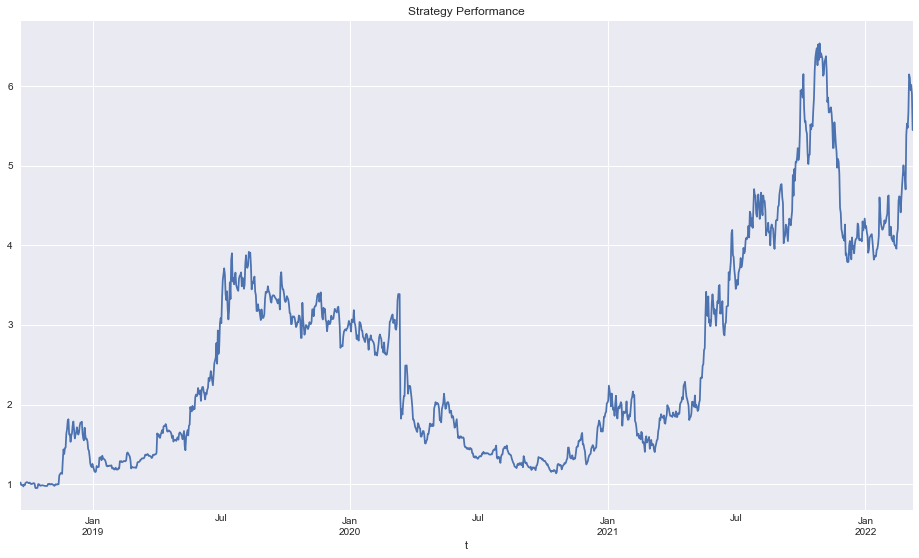

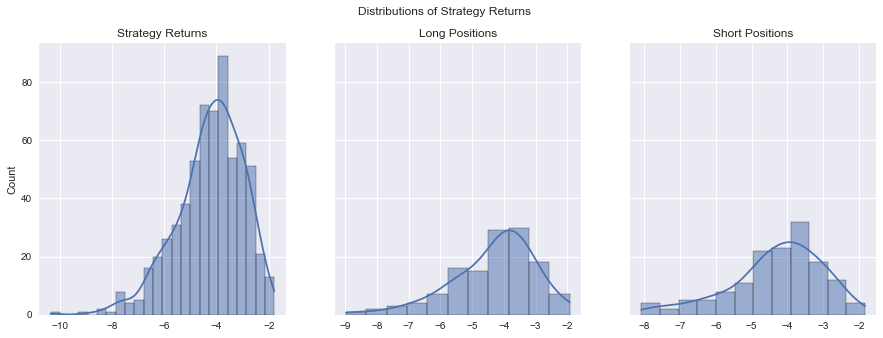

In [150]:
lin = Linearized(data, training_size = .70)

lin.test_strategy()
lin.plot_results()
lin.plot_diagnostics()

In [152]:
lin.score

-0.04365529569389892

Despite the hit ratio is not that high, this model might is not able to bring consistent performance, the returns distribution is skewed to the left and therefore we shouldn't use this as a model to predict the direction of the market.

## A Logistic Regression Model



Fitting 3 folds for each of 10 candidates, totalling 30 fits
STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 660.0
Number of Winners: 147
Number of Loosers: 513.0


Win Ratio: 0.2
Loose Ratio: 0.8
Sharpe Ratio:                -0.0151


Terminal Wealth: 0.661
Maximum Drawdown: -1.0508


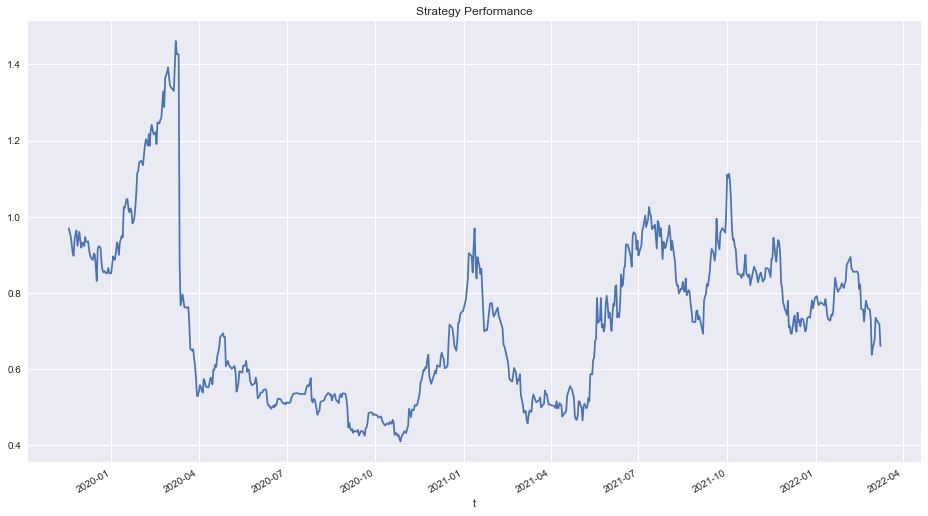

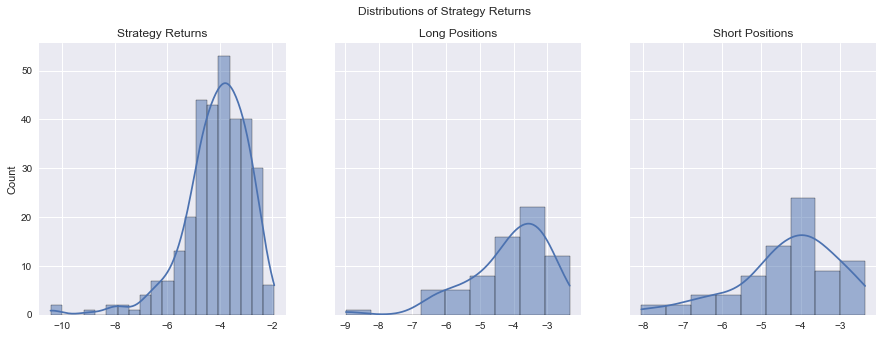

In [170]:
param_grid = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
              'max_iter' : [100, 1000, 2500, 5000]
              }



logit = Logit(data, training_size = 0.80)
logit.optimize_strategy(param_grid)
logit.plot_results()
logit.plot_diagnostics()

In [171]:
#Logistic Regression Accuracy on predicting market movement

logit.score

0.5218934911242603

# A Random Forest Classification model

Fitting 3 folds for each of 10 candidates, totalling 30 fits
STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
TRADING PERFORMANCE MEASURES:


Number of Trades: 226.0
Number of Winners: 56
Number of Loosers: 170.0


Win Ratio: 0.2
Loose Ratio: 0.8
Sharpe Ratio:                0.0931


Terminal Wealth: 52.791
Maximum Drawdown: -31.7162


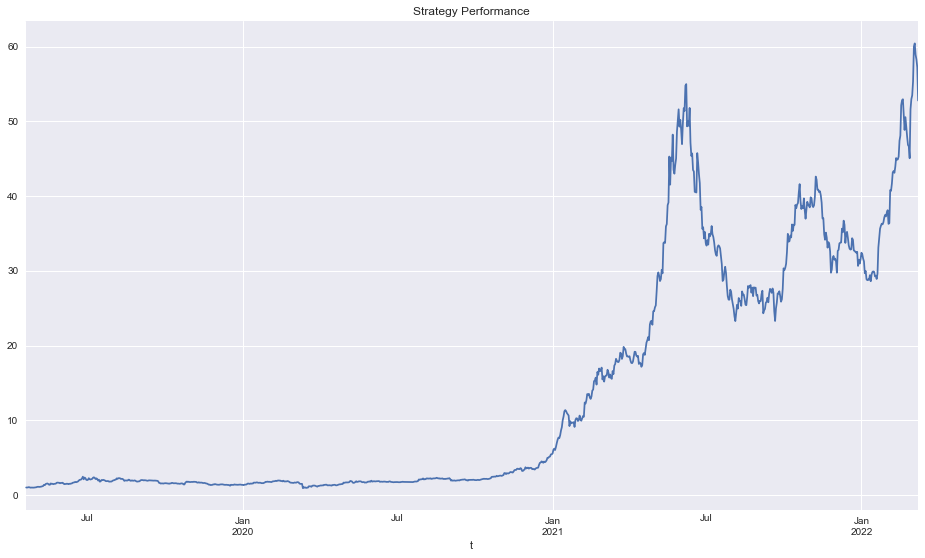

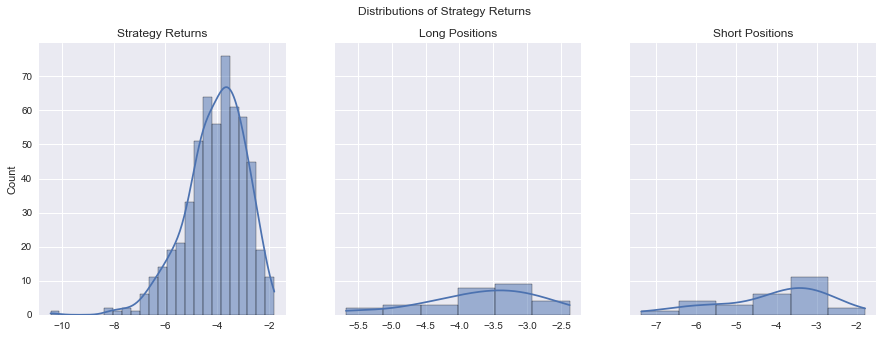

In [158]:
#random state of the decision tree
random_state = np.arange(0,102,2)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4,6,8,10]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'random_state': random_state,
              'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}


params = pd.DataFrame(dict(random_state = 5, 
              n_estimators = 56, 
              min_samples_split = 7,
              min_samples_leaf = 2,
              max_features = 'auto',
              max_depth = 2,
              bootstrap = True), index = [0])

forest = Forest(data, training_size = 0.75)

forest.optimize_strategy(param_grid)
forest.plot_results()
forest.plot_diagnostics()

In [172]:
#Accuracy of the random forest on predicting the market movements

forest.score

0.5250709555345316

# Conclusion


We have seen a that with the provided amount of data models fail to make consistent prediction, we only have an advantage of just 2% on knowing what is the result of a coin flip. This model could be used to manage part of the risk in a systematic strategy. Namely, when the market is forecasted to be uptrend, then we could increase the take profit on the long positions and reducing the take profit in the short position, whereas when the market is forecasted to be downtrend then we could increase the take profit on the short position and reducing the take profit in the long positions.